---
title: "Trait-wise principal components after dimensionality reduction"
author: "Saikat Banerjee"
format:
  html: default
  ipynb: default
date: "2023-06-05"
---

# About

Here, I try to qualitatively compare the different dimensionality reduction methods in terms of their ability to distinguish the different traits. Suppose $\mathbf{X}$ is the $N \times P$ input matrix, with $N$ traits and $P$ associated variants. The dimensionality reduction methods decompose the input matrix into a sparse low rank component, $\mathbf{L}$ and a background $\mathbf{M}$,
$$
\mathbf{X} \sim \mathbf{L} + \mathbf{M}
$$
We perform PCA on the low rank matrix $\mathbf{L}$ using the SVD,
$$
\mathbf{L} = \mathbf{U}\mathbf{S}\mathbf{V}^{\intercal}
$$
Then, the principal components are given by the columns of $\mathbf{U}\mathbf{S}$. The traits are broadly classified into NPD phenotypes. For each "broad phenotype" $T$ and principal component $k$, **we define the trait-wise PC score as**,
$$
V_{tk} = \sum_{t \in T}(U_{tk}S_k)^2
$$
Note, the total variance explained by the component is $\sum_{i}(U_{ik}S_k)^2 = S_k^2$.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from nnwmf.functions.frankwolfe import frank_wolfe_minimize, frank_wolfe_cv_minimize
from nnwmf.functions.robustpca import RobustPCA

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

# Data

Summary statistics data for NPD is collected from PGC, OpenGWAS and GTEx. [See previous work](https://banskt.github.io/npd-notes/explore/preprocess_npd_gtex_pgc_ieu.html) for data cleaning and filtering. Our input is the Z-Score matrix for $N$ diseases and $P$ variants.

In [4]:
data_dir = "../data"
beta_df_filename  = f"{data_dir}/beta_df.pkl"
prec_df_filename  = f"{data_dir}/prec_df.pkl"
trait_df_filename = f"{data_dir}/trait_meta.csv"


'''
Data Frames for beta, precision, standard error and zscore.
'''
beta_df = pd.read_pickle(beta_df_filename)
prec_df = pd.read_pickle(prec_df_filename)
se_df = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan)
zscore_df = beta_df / se_df
zscore_df = zscore_df.replace(np.nan, 0)

trait_df = pd.read_csv(trait_df_filename)
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [5]:

'''
Filter samples using mean of SE and std of beta
'''

mean_se = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan).mean(axis = 0, skipna = True)
mean_se = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)
select_ids = error_df.query("mean_se <= 0.2 and beta_std <= 0.2").index

X = np.array(zscore_df[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"After filtering, we have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

After filtering, we have 69 samples (phenotypes) and 8403 features (variants)


We perform PCA (using SVD) on the raw input data (mean centered). In @fig-input-pca-pve, we look at the proportion of variance explained by each principal component. 

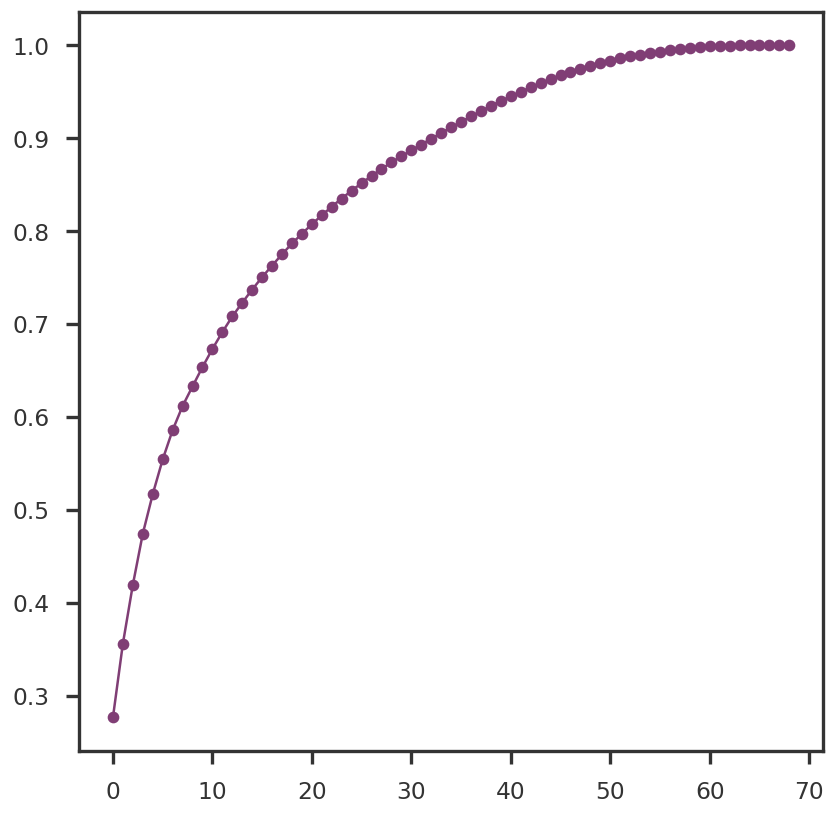

In [110]:
#| label: fig-input-pca-pve
#| fig-cap: "Proportion of variance explained by the principal components of the input matrix"

U, S, Vt = np.linalg.svd(Xcent, full_matrices = False)
S2 = np.square(S)
pcomp = U @ np.diag(S)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
plt.show()

# Trait-wise PC score

We break down the total variance $V_1$ explained by the first principal component for each trait.
In @fig-trait-wise-pve-pc1-input-data, we show $V_{t1} / $V_1$, and note that the first component explains the variance in SZ and BD. 

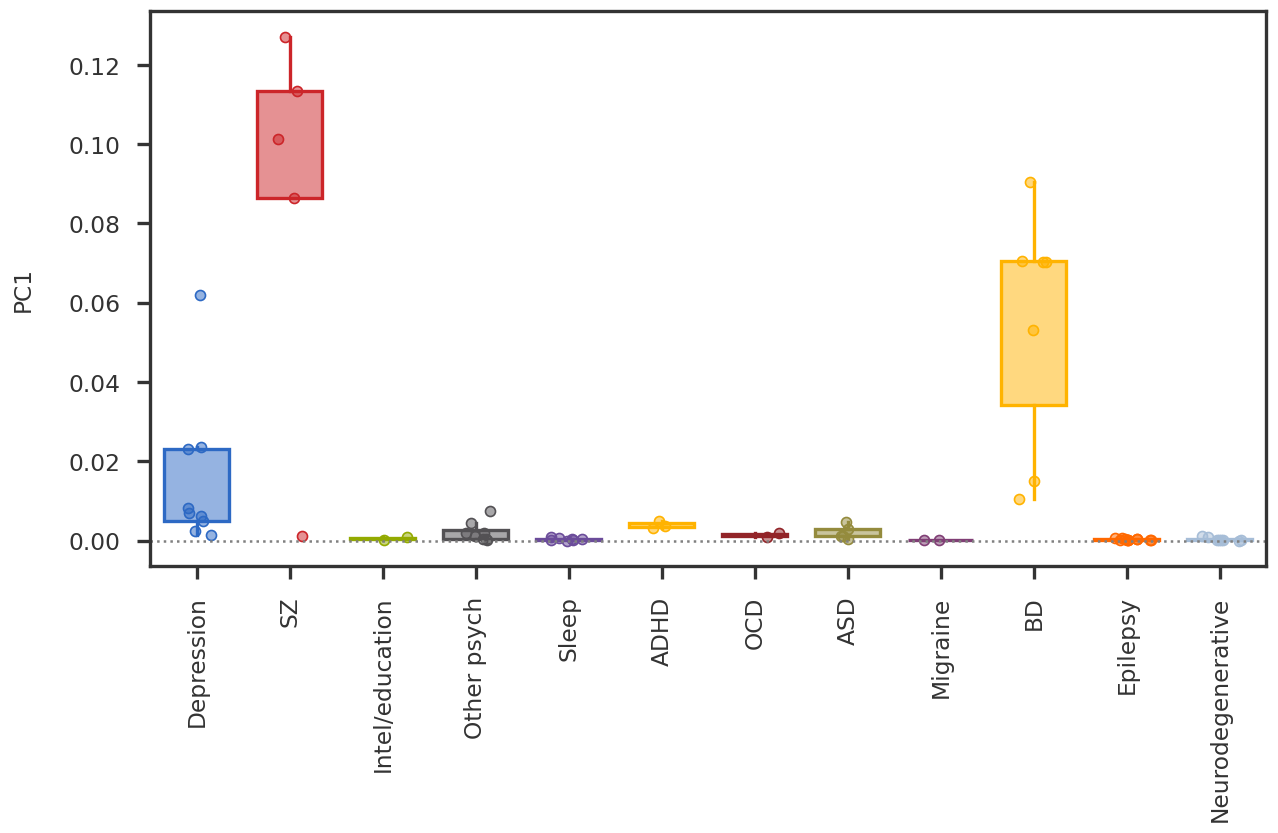

In [111]:
#| label: fig-trait-wise-pve-pc1-input-data
#| fig-cap: "Trait-wise PVE by the first principal component of the input matrix"

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
nsample = pcomp.shape[0]
ntrait  = len(unique_labels)



pcidx = 0
tot_variance  = np.square(S[pcidx])

trait_indices = [np.array([i for i, x in enumerate(labels) if x == label]) for label in unique_labels]
trait_pcomps  = [np.square(pcomp[idx, pcidx]) / tot_variance for idx in trait_indices]
trait_colors  = {trait: color for trait, color in zip(unique_labels, (mpl_stylesheet.banskt_colors() + mpl_stylesheet.kelly_colors())[:ntrait])}

def rand_jitter(n, d = 0.1):
    return np.random.randn(n) * d

for ilbl, label in enumerate(unique_labels):
    xtrait = trait_pcomps[ilbl]
    nsample = xtrait.shape[0]
    
    boxcolor = trait_colors[label]
    boxface = f'#{boxcolor[1:]}80' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
    medianprops = dict(linewidth=0, color = boxcolor)
    whiskerprops = dict(linewidth=2, color = boxcolor)
    boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
    flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
    
    ax1.boxplot(xtrait, positions = [ilbl],
                showcaps = False, showfliers = False,
                widths = 0.7, patch_artist = True, notch = False,
                flierprops = flierprops, boxprops = boxprops,
                medianprops = medianprops, whiskerprops = whiskerprops)
    
    ax1.scatter(ilbl + rand_jitter(nsample), xtrait, edgecolor = boxcolor, facecolor = boxface, linewidths = 1)


ax1.axhline(y = 0, ls = 'dotted', color = 'grey')
ax1.set_xticks(np.arange(len(unique_labels)))
ax1.set_xticklabels(unique_labels, rotation = 90)
ax1.set_ylabel(f"PC{pcidx + 1:d}")

plt.show()

In [94]:
def plot_traitwise_pc_scores(ax, U, S, unique_labels, trait_colors, min_idx = 0, max_idx = 20, alpha = 0.6,
                             use_proportion = True):
    trait_pcomps_all = dict()
    pcindices = np.arange(min_idx, max_idx)
    pcomp = U @ np.diag(S)

    for pcidx in pcindices:
        tot_variance = np.square(S[pcidx])
        if use_proportion:
            trait_pcomps_all[pcidx] = [np.square(pcomp[idx, pcidx]) / tot_variance for idx in trait_indices]
        else:
            trait_pcomps_all[pcidx] = [np.square(pcomp[idx, pcidx]) for idx in trait_indices]
    
    comp_weights = {
        trait: [np.sum(trait_pcomps_all[pcidx][ilbl]) for pcidx in pcindices] for ilbl, trait in enumerate(unique_labels)
    }

    bar_width = 1.0
    bottom = np.zeros(len(pcindices))

    for trait, comp_weight in comp_weights.items():
        ax.bar(pcindices, comp_weight, width, label=trait, bottom=bottom, color = trait_colors[trait], alpha = alpha)
        bottom += comp_weight

    ax.set_xticks(pcindices)
    ax.set_xticklabels([f"{i + 1}" for i in pcindices])

    for side, border in ax.spines.items():
        border.set_visible(False)

    ax.tick_params(bottom = True, top = False, left = False, right = False,
                   labelbottom = True, labeltop = False, labelleft = False, labelright = False)
    
    return

We can do the same for each principal component and show the trait-wise PC-score for each component, as shown in the top panel of @fig-trait-wise-pca-score-input-data. In such representation, we lose the information of the total variance by the component, but it gives an idea of the ability of the component to distinguish different phenotypes. In the bottom panel, we retain the information of the total variance explained (by avoiding the scaling to 1.0) but it is difficult to see the utility of the components with lower variance.

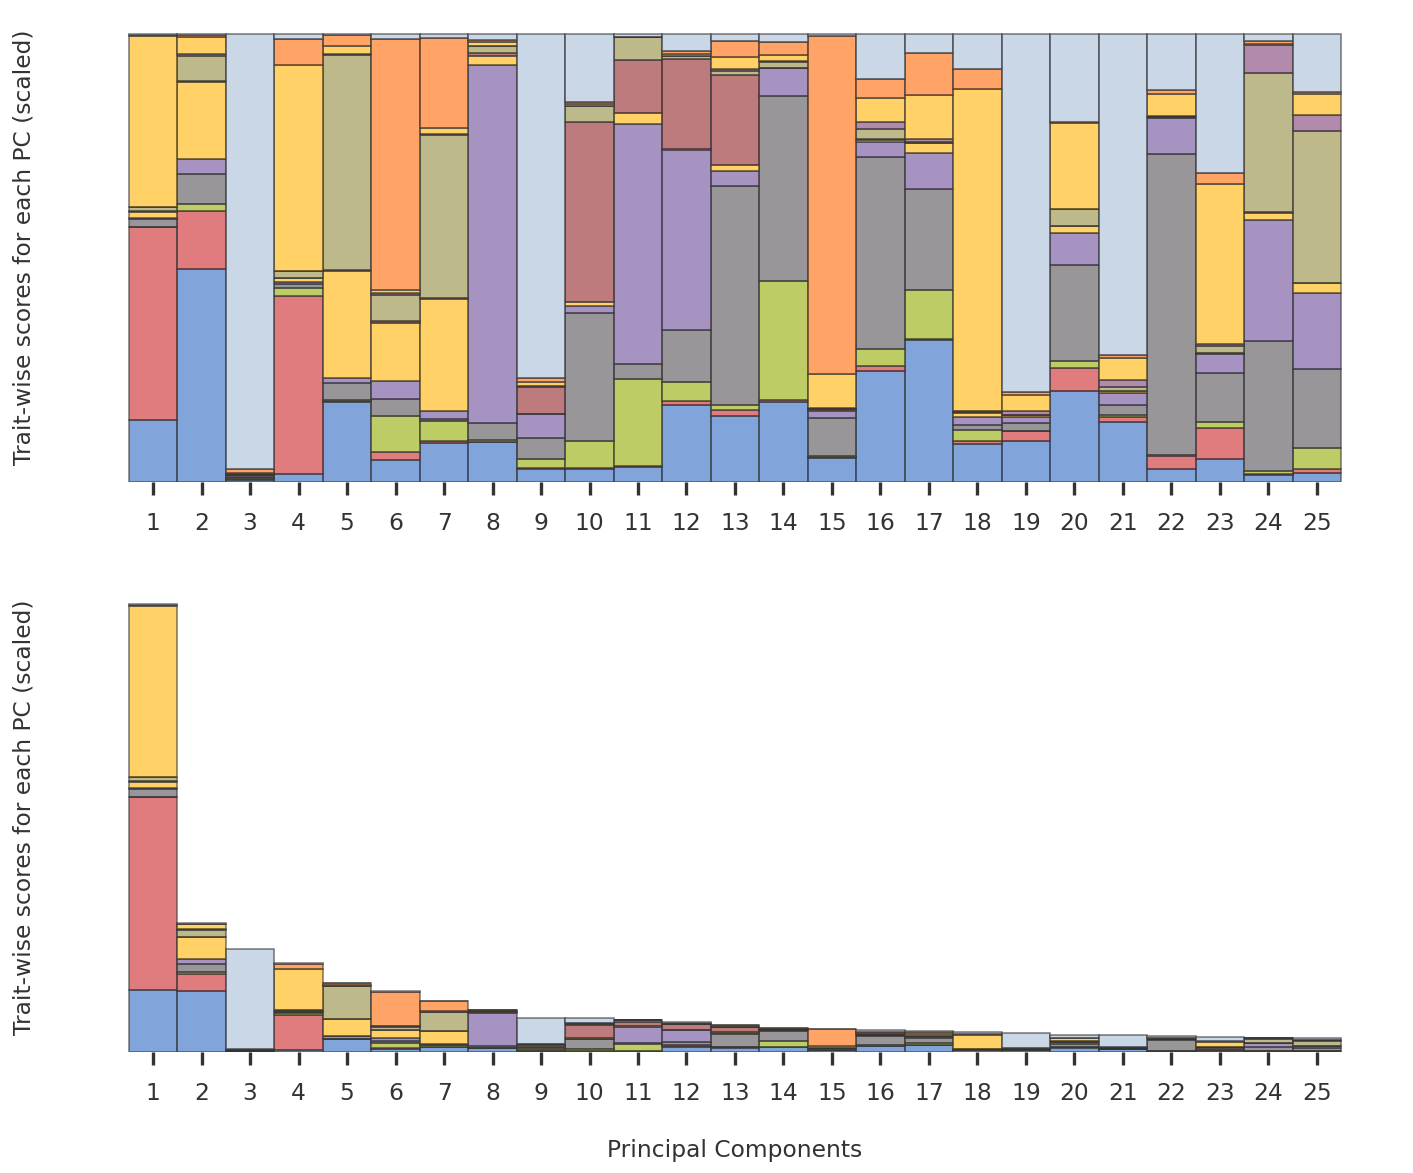

In [112]:
#| label: fig-trait-wise-pca-score-input-data
#| fig-cap: "Trait-wise PVE by the first principal component of the input matrix"

fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plot_traitwise_pc_scores(ax1, U, S, unique_labels, trait_colors, max_idx = 25)
plot_traitwise_pc_scores(ax2, U, S, unique_labels, trait_colors, max_idx = 25, use_proportion = False)

ax2.set_xlabel("Principal Components")
ax1.set_ylabel("Trait-wise scores for each PC (scaled)")
ax2.set_ylabel("Trait-wise scores for each PC (scaled)")
plt.tight_layout(h_pad = 2.0)
plt.show()

# Experiment

Here, we perform the low-rank approximation using two methods:
  - Robust PCA
  - Nuclear Norm Matrix Factorization using Frank-Wolfe Algorithm

In [46]:
rpca = RobustPCA(lmb=0.0085, max_iter=1000)
L_rpca, M_rpca = rpca.fit(Xcent)

In [97]:
r_opt = 4096.
L_cvopt, _, _ = frank_wolfe_minimize(Xcent, np.ones(Xcent.shape), r_opt, max_iter = 100)
M_cvopt = Xcent - L_cvopt

In [100]:
L_rpca_cent = L_rpca - np.mean(L_rpca, axis = 0, keepdims = True)
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(L_rpca_cent, full_matrices = False)

L_cvopt_cent = L_cvopt - np.mean(L_cvopt, axis = 0, keepdims = True)
U_cvopt, S_cvopt, Vt_cvopt = np.linalg.svd(L_cvopt_cent, full_matrices = False)

M_cvopt_cent = M_cvopt - np.mean(M_cvopt, axis = 0, keepdims = True)
U_cvopt2, S_cvopt2, Vt_cvopt2 = np.linalg.svd(M_cvopt_cent, full_matrices = False)

In @fig-trait-wise-pca-score-low-rank, we compare the trait-wise PC scores obtained from the two methods. Note that, I am not showing the first component because the first component is very similar for the input data and the low-rank approximations. Neglecting the first component also allows me to look at the unscaled component-wise PC scores without losing too much information about the components with lower eigenvalues.

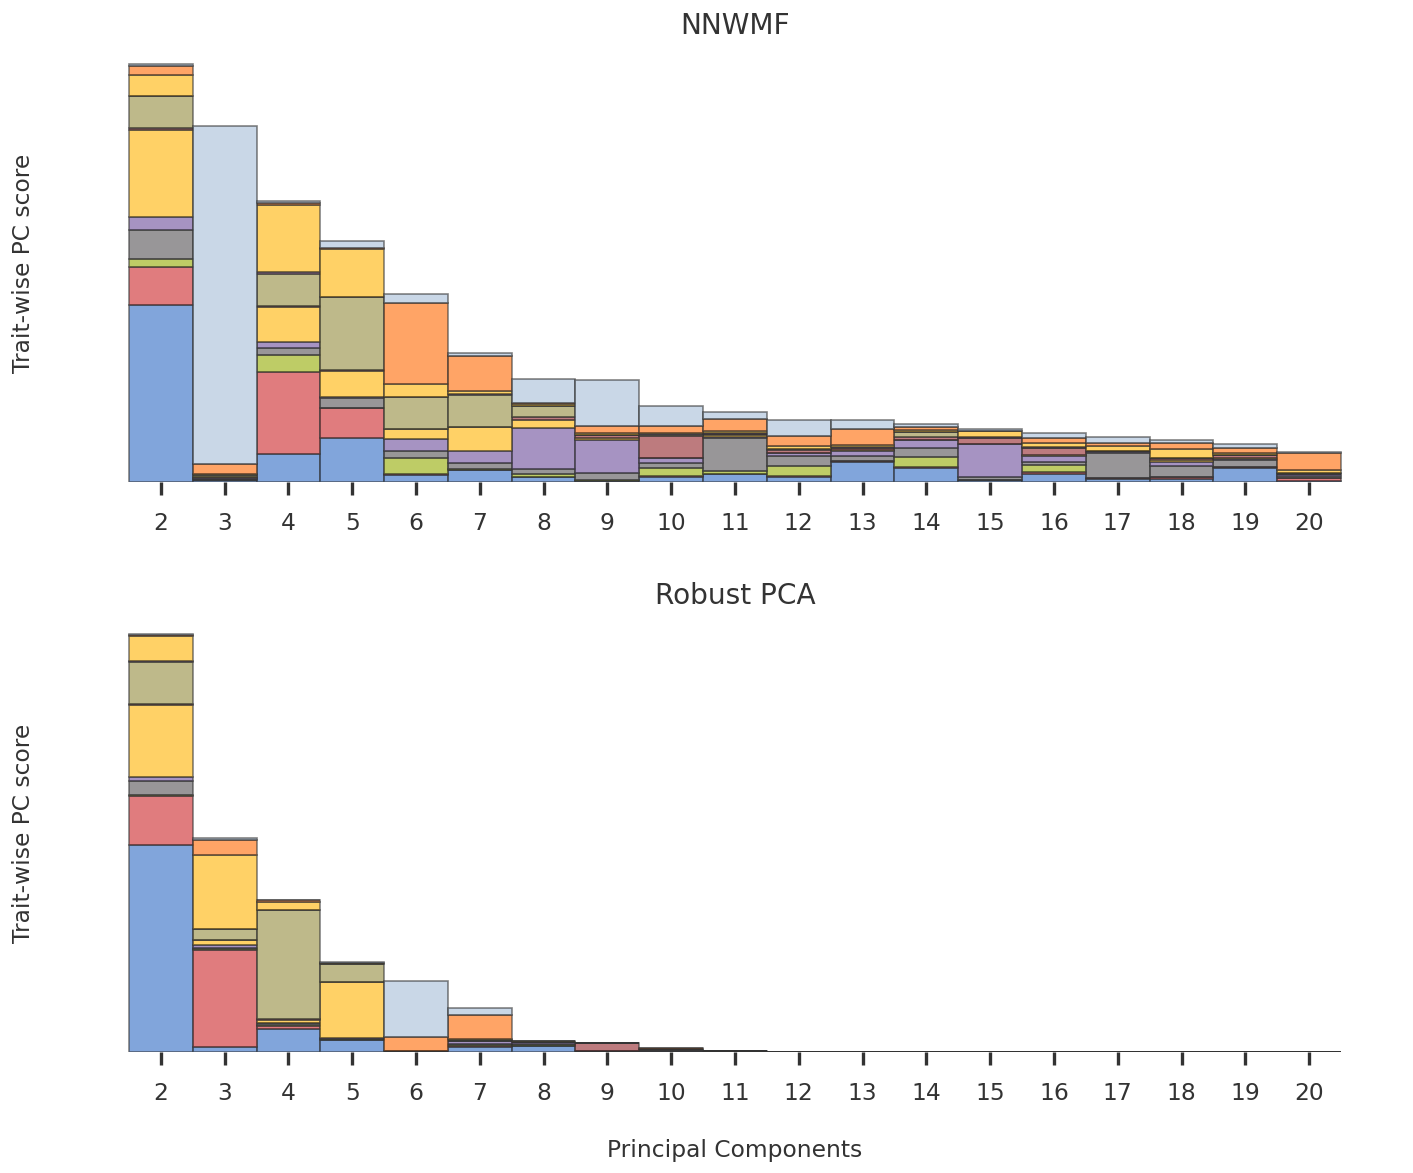

In [113]:
#| label: fig-trait-wise-pca-score-low-rank
#| fig-cap: "Trait-wise PC scores for the low rank approximation of the input matric"

fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_traitwise_pc_scores(ax1, U_cvopt, S_cvopt, unique_labels, trait_colors, min_idx = 1, max_idx = 20, use_proportion = False)
#plot_traitwise_pc_scores(ax2, U_cvopt2, S_cvopt2, unique_labels, trait_colors, max_idx = 10, use_proportion = False)
plot_traitwise_pc_scores(ax2, U_rpca, S_rpca, unique_labels, trait_colors, min_idx = 1, max_idx = 20, use_proportion = False)

ax1.set_title("NNWMF")
ax2.set_title("Robust PCA")

ax2.set_xlabel("Principal Components")
ax1.set_ylabel("Trait-wise PC score")
ax2.set_ylabel("Trait-wise PC score")

plt.tight_layout(h_pad = 2.0)
plt.show()